In [65]:
%matplotlib inline

#version 1

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML, display
display(HTML("<style> .container { width:100%; }</style>")) #jupyter full screen width
display(HTML("<style> .CodeMirror pre { font-size: 12pt; line-height: 110%;} </style>")) #jupyter font
figSize = (18,12) #figure size
lW = 1 #line width for graphs

## Constants setup

In [66]:
pLen      = 1    # pendulum length, meters
pLenError = 0.02  # pendulum length error. TRY VARIOUS VALUES
g = 9.81   #gravitational acceleration
dT = 0.01  #simulation time increment
N = 1000   #time steps
aVel = 0 #initial velocity
iAngle     = np.pi/20  #initial angle
iAngleError = 0.02     #initial angle error. TRY VARIOUS VALUES

vxSS    = 0.2 # radar vx variance. TRY VARIOUS VALUES
vxBias  = 0.02 # radar systematic error. TRY VARIOUS VALUES
alSS    = 0.01 # accelerometer variance. TRY VARIOUS VALUES
alBias  = 0.00 # accelerometer systematic error. TRY VARIOUS VALUES
avSS    = 0.01 # accelerometer variance. TRY VARIOUS VALUES
avBias  = 0.00 # accelerometer systematic error. TRY VARIOUS VALUES

angl = iAngle
time = 0
vx = [] 
al = []
av = []
tList = []
angleList = []



In [67]:
for i in range(N):
    vx.append(aVel*pLen*np.cos(angl))
    al.append(g*np.cos(angl) - aVel*aVel*pLen)
    av.append(g*np.sin(angl))    
    angleList.append(angl)
    tList.append(time)
    
    time = time + dT
    aVel = aVel +  g * np.sin(angl) * dT / pLen
    angl = angl -  aVel * dT


vx = vx + np.random.normal(vxBias, vxSS, N) 
al = al + np.random.normal(alBias, alSS, N) 
av = av + np.random.normal(avBias, avSS, N) 

inData = np.stack((tList, vx, [vxSS+vxBias*vxBias] * N, al, [alSS+alBias*alBias] * N, av, [avSS+avBias*avBias] * N)).T

print(inData)

[[ 0.          0.12529852  0.2004     ...  0.01        1.52332987
   0.01      ]
 [ 0.01       -0.06109144  0.2004     ...  0.01        1.53392535
   0.01      ]
 [ 0.02       -0.33996435  0.2004     ...  0.01        1.53791223
   0.01      ]
 ...
 [ 9.97        0.42530834  0.2004     ...  0.01        1.50236631
   0.01      ]
 [ 9.98       -0.20627947  0.2004     ...  0.01        1.51100289
   0.01      ]
 [ 9.99       -0.23402571  0.2004     ...  0.01        1.53513118
   0.01      ]]


# Algorithm Description - TODO

## Kalman Filter
### Equations
\begin{equation*}
Prediction\\
\bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q\\
Update\\
\mathbf y = \mathbf z - \mathbf{H\bar x}\\
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1}\\
\mathbf x = \bar{\mathbf x} + \mathbf{Ky}\\
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}}
\end{equation*}


## Design
### State Variables
### State Transition Function
### Process Noise Matrix
### Control Function


In [68]:
# you need to improve this function 
# this solution does not improve use the radar data
# and, also, does not attempt to estimate the pendulum length, gyro and radar bias
# only works well if the gyro is accurate and has no bias.
# does not even use pendulum physics (gravitation?)
def estimateGyro(measurements, angle, pendLen, g):
    N = measurements.shape[0]
    oldT = 0
    aList = []
    for i in range(N):
        (t, vx, vxSS, al, alSS, av, avSS) = tuple(measurements[i,:])
        dt = t - oldT
        oldT = t
        angle = angle - vx / pendLen * dt # silly approximation v=v_x
        aList.append(angle)
    return (aList, pendLen, 0, 0, 0) 
        
    

RMS Angle Estimation Error: 4.32215555861954
Estimated Pendulum Length: 1.02  Real Penndulum length: 1
Estimated Radar bias: 0  Real Radar bias: 0.02
 Estimated AccL bias: 0   Real AccL bias: 0.0
 Estimated AccV bias: 0   Real AccV bias: 0.0


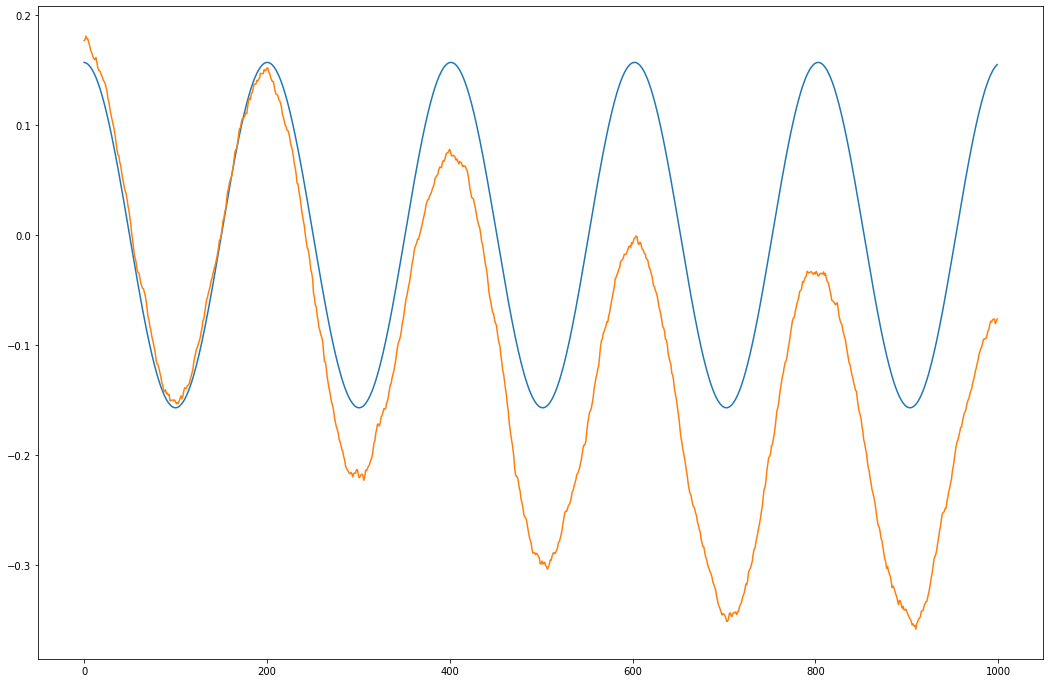

In [69]:
    
    
(e_aList, e_penLen, e_vxBias, e_alBias, e_avBias) = estimateGyro(inData, iAngle+iAngleError, pLen+pLenError, g)

fig, ax = plt.subplots(figsize=figSize)
ax.plot(angleList) # the real angle
#ax.plot(w)
ax.plot(e_aList) # the estimated angle, obviously drifting due to gyroBias (constant error in the angular velocity speed)

print('RMS Angle Estimation Error:', np.sqrt(np.sum((np.array(e_aList)-np.array(angleList))**2)))
print('Estimated Pendulum Length:',e_penLen,' Real Penndulum length:', pLen)
print('Estimated Radar bias:', e_vxBias,' Real Radar bias:', vxBias)
print(' Estimated AccL bias:', e_alBias,'  Real AccL bias:', alBias)
print(' Estimated AccV bias:', e_avBias,'  Real AccV bias:', avBias)

